In [3587]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt
import numpy as np
# my plotting style, please use your own!
plt.style.use('~/Documents/code/stylelib/madx.mplstyle')

In [3588]:
# initiate madx
madx = Madx()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2024.07.22 15:47:05      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [3589]:
madx.command.title('R3 Ring for Position Schottky dX measurement')

True

In [3590]:
# parameters
amu_mev = 931.49410242 # MeV
beam_energy = 200.0 # MeV/u
circumference = 60.35075196 # from madx, not geometrical
n_turns = 1 # full turns of the ring (for twiss calculation)
dp_modifier = 0.0 # adjusts k0 of the dipole which alters the bending strength
# (k0 = angle/arclength)

In [3591]:
# input n_turns for sequence file
madx.input(f'n_turns = {n_turns};')
madx.input(f'dp_modifier = {dp_modifier};')
# call sequence
madx.call(file='r3_center.seq')

! r3 ring sequence with refer = center for use of makethin command etc.

! G.Hudson-Chang June 2024



! ===== parameters =====

full_gap = 0.08; ! Full width pole to pole gap [m]

b_angle = 15*raddeg; ! Bending angle [rad.]

b_rad_tarnd = 4.045; ! Bending radius of TARNII-D [m]



! ===== lengths =====

l_dp = b_rad_tarnd*b_angle; ! length of dipole

l_dp_drft = 0.6; ! drift section between R3 dipoles



l_str = 4.022544566; ! straight section

l_str_hf = 2.011272283; ! half straight section



l_r3_bend = 4*l_dp+3*l_dp_drft; ! length of r3_bend section

l_r3_bend_hf = l_r3_bend/2; ! length of r3_bend section

l_ring = 6*l_r3_bend+6*l_str;



! ===== dipole magnets =====

! ring dipole with trim coil

dp_trim: sbend, 

        l = l_dp,

        angle = b_angle,

        hgap = full_gap/2,

        ! tilt = 0.0*raddeg,

        e1 = 7.5*pi/180,

        e2 = 7.5*pi/180,

        fint = 0.654, ! fint is same as old tarnii-file

        ktap = dp_modifier,

        k1 = 0.0739951, ! til

In [3592]:
# initiate beam with initial conditions
madx.command.beam(
    mass = 70*amu_mev/1000, # input is GeV
    charge = 30.0,
    energy = 70*(amu_mev+beam_energy)/1000, # also GeV
    sigt = 4.4616, # bunch length
    sige = 0.001, # rel energy spread
    kbunch = 18, # n bunches in machine
    radiate = True, # synchrotron radiation
    bunched = True,
)

True

In [3593]:
# use the beam in the sequence
madx.use(sequence = 'full_ring')

In [3594]:
# matching - copied from old ring file by Y. Yamaguchi
madx.command.match(sequence = 'full_ring')
madx.command.constraint(mux = 1.216)
madx.command.vary(NAME = 'dp_trim->k2', step = 0.001, lower = -1.0, upper = 1.0)
madx.command.simplex(calls = 100000, tolerance = 1.0e-12)
madx.command.endmatch()

START MATCHING

number of sequences: 1
sequence name: full_ring
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
number of variables:    1
user given constraints: 1
total constraints:      74

START SIMPLEX:

++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed o

True

In [3595]:
madx.use(sequence='full_ring')

In [3596]:
twiss = madx.twiss(deltap = '-0.005,0.0,0.005')

enter Twiss module
  
iteration:   1 error:   3.614693E-02 deltap:  -5.000000E-03
orbit:  -3.316949E-02 -6.122167E-06  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   7.061123E-05 deltap:  -5.000000E-03
orbit:  -3.318997E-02 -1.779256E-08  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.624422E-09 deltap:  -5.000000E-03
orbit:  -3.318997E-02 -1.778213E-08  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.

++++++ table: summ

            length             orbit5               alfa            gammatr 
       60.35075196                 -0       0.6713807309        1.220437557 

                q1                dq1            betxmax              dxmax 
       1.221731709      -0.2968218824        8.066193926         11.6758669 

             dxrms             xcomax

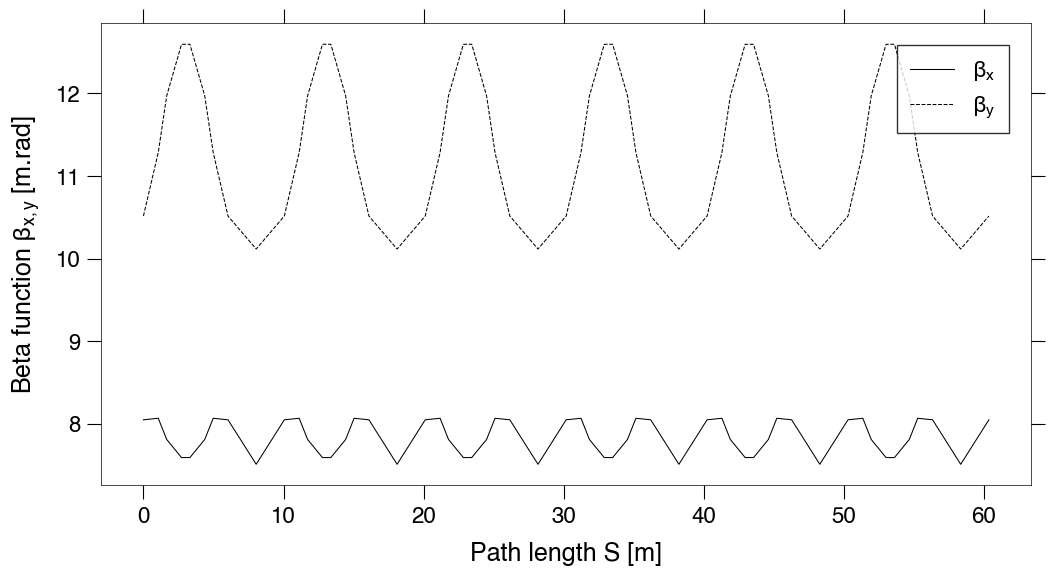

In [3597]:
# low res. initial beta function plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
ax.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='black', linestyle='--')

ax.set_xlabel('Path length S [m]')
ax.set_ylabel(r'Beta function $\beta_{x,y}$ [m.rad]')

ax.legend();

In [3598]:
# tracking with ptc module

# invoke ptc tracking module
madx.command.ptc_create_universe()

# create layout
madx.command.ptc_create_layout(
    model = 2, # matrix-kick-matrix model
    method = 6, # integration order
    nst = 10, # no. of integration steps for each element
    # offset_deltap=0
    # exact = True, # flag to switch on exact hamiltonian
)
# additional options
madx.command.ptc_setswitch(
    fringe = True, # fringe field effects
    radiation = False, # synchrotron radiation
    time = True,
    totalpath=True,
    debuglevel = 2,
)
# initialise particle
madx.command.ptc_start(x=0.001, pt=0.0) # p001
madx.command.ptc_start(x=0.16, pt=0.001) # p002
madx.command.ptc_start(x=0.04, pt=0.003) # p003

# add observation point
madx.command.ptc_observe(place = 'bpm_schottky')

# number of turns for ptc
n_turns_ptc = 2000

madx.command.ptc_track(
        icase = 6, # important, not sure why yet
        # deltap = 0.0,
        closed_orbit = True, # co-ordinates specified with respect to actual closed orbit, not reference orbit (if True)
        element_by_element = True,
        turns = n_turns_ptc,
        maxaper = [0.24, 0.03, 0.05, 0.01, 1.0, 0.1], # maximum aperture
        file = 'data/r3_track_ipynb',
        extension = '.out',
)

Determined SECTOR NMUL MAX :  3
 MAD-X Beam Parameters
                  Energy : 0.792046E+02
          Kinetic Energy : 0.140000E+02
      Particle Rest Mass : 0.652046E+02
                Momentum : 0.449636E+02
 Cannot do spin : provide a=g-2. Now it is set to zero.
 Setting MADx with 
     energy           79.204587169400000     
     method                   6
     Num. of steps           10
     charge           1.0000000000000000     
  Length of machine:    60.350751963541470     
 The machine is a RING
 ------------------------------------ PTC Survey ------------------------------------
 Before start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 Before   end:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After  start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After    end:    3.5122108657538453E-014   0.0000000000000000       -1.2434497875801753E-014
 Setting debug level

True

In [3599]:
# import data from bpm in the centre of the schottky straight section
p001 = np.transpose(np.genfromtxt('data/r3_track_ipynb.obs0002.p0001.out', skip_header=8))
p002 = np.transpose(np.genfromtxt('data/r3_track_ipynb.obs0002.p0002.out', skip_header=8))
p003 = np.transpose(np.genfromtxt('data/r3_track_ipynb.obs0002.p0003.out', skip_header=8))

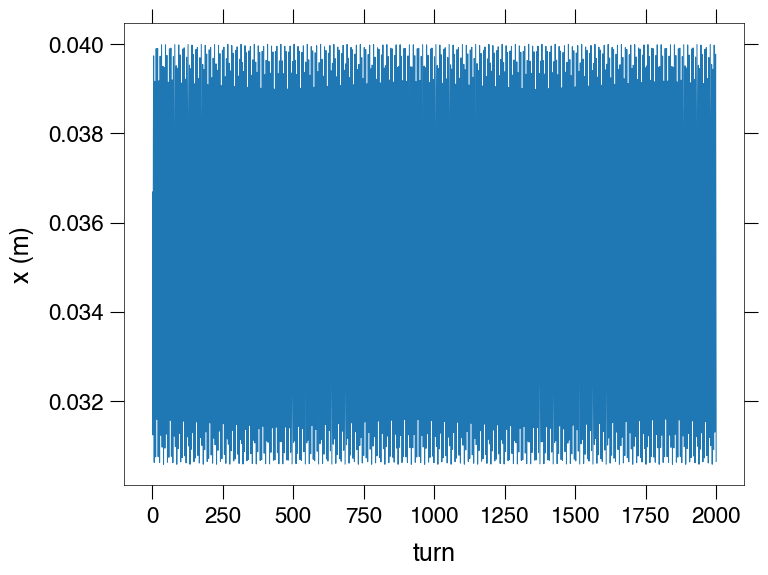

In [3600]:
# x vs turns for bpm in the centre of the schottky straight section
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(p003[1], p003[2])

ax.set_xlabel('turn')
ax.set_ylabel('x (m)')
plt.show()

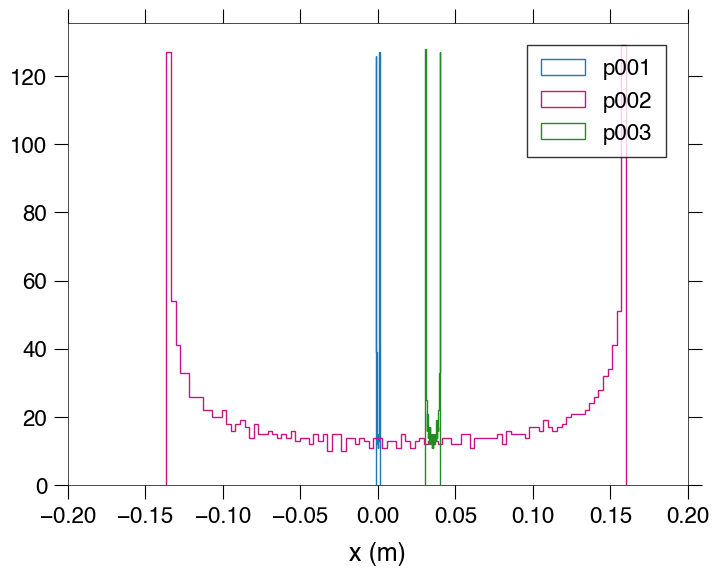

In [3613]:
# x axis distribution at the position schottky bpm
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(p001[2],
        bins=100,
        histtype='step',
        label='p001'
        )
ax.hist(p002[2],
        bins=100,
        histtype='step',
        label='p002',
        color='mediumvioletred'
        )
ax.hist(p003[2],
        bins=100,
        histtype='step',
        label='p003',
        color='forestgreen'
        )

ax.set_xlabel('x (m)')
ax.set_xlim([-0.2,0.2])
ax.legend()

plt.savefig(f'plots/x_dispersion.pdf', bbox_inches='tight')

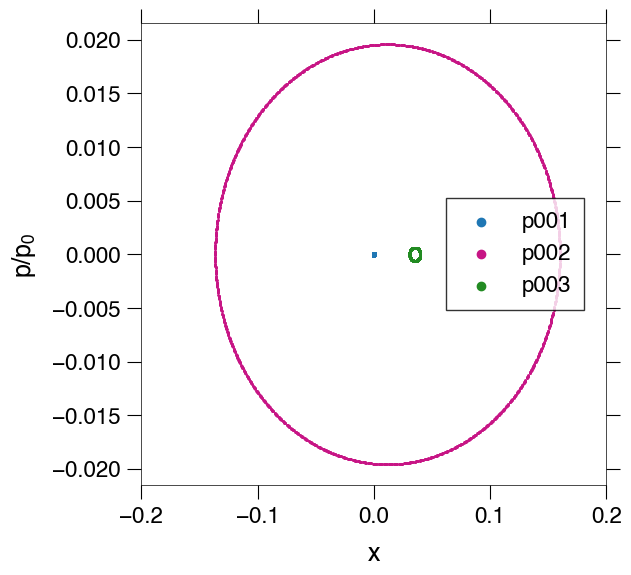

In [3629]:
# x vs px (phase space of x)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(p001[2], p001[3], label='p001', linestyle='-',)
ax.scatter(p002[2], p002[3], label='p002', linestyle='-', color='mediumvioletred')
ax.scatter(p003[2], p003[3], label='p003', linestyle='-', color='forestgreen')

ax.set_xlabel('x')
ax.set_ylabel('$p/p_0$')
ax.set_xlim([-0.2,0.2])
# ax.set_ylim([-0.01,0.01])

plt.legend(markerscale=6)

plt.savefig(f'plots/x_phasespace.pdf', bbox_inches='tight')

In [3630]:
coeff = np.polyfit(p001[1], p001[6], 1, full=True)
coeff

(array([ 106.30938652, -106.30938363]),
 array([0.00241738]),
 2,
 array([1.36606501, 0.36587754]),
 4.440892098500626e-13)

In [3631]:
coeff = np.polyfit(p002[1], p002[6], 1, full=True)
coeff

(array([ 106.31944887, -106.31328303]),
 array([53.03058138]),
 2,
 array([1.36606501, 0.36587754]),
 4.440892098500626e-13)

In [3632]:
coeff = np.polyfit(p003[1], p003[6], 1, full=True)
coeff

(array([ 106.31045088, -106.2976801 ]),
 array([0.05347505]),
 2,
 array([1.36606501, 0.36587754]),
 4.440892098500626e-13)

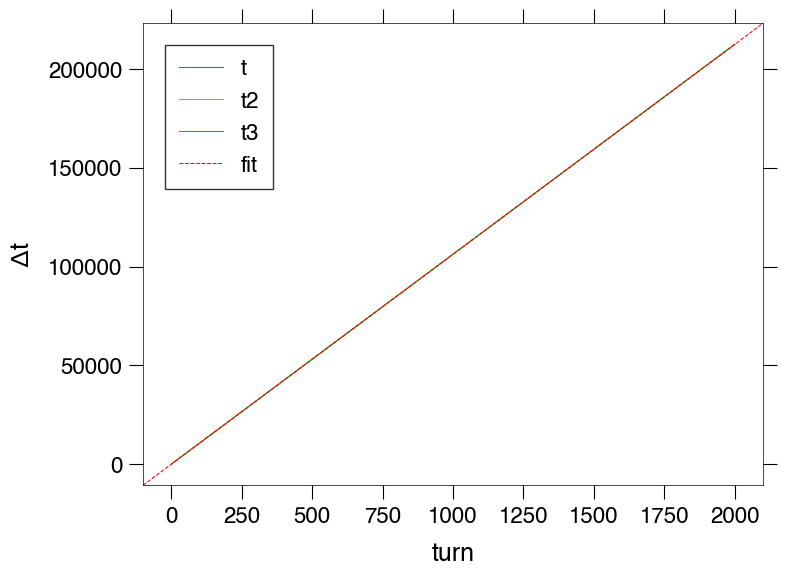

In [3633]:
# tof for each particle
# x vs turns for bpm in the centre of the schottky straight section
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(p001[1], p001[6], label = 't')
ax.plot(p002[1], p002[6], label = 't2')
ax.plot(p002[1], p002[6], label = 't3')
ax.axline(xy1=(0, coeff[0][1]), slope=coeff[0][0], 
          linestyle = '--',
          color = 'red',
          label = 'fit')

ax.set_xlabel('turn')
ax.set_ylabel('$\Delta$t')
ax.legend()

plt.show()
